In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
path = os.getcwd()

* 데이터셋

In [3]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


* 앙상블 학습

In [316]:
class tree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)


    def obj_fun(self, l_values, r_values):
        # 고농도지점의 오차에 가중치를 더 주는 방식으로 수정할 필요가 있음

        # np.mean(y, axis = 0)
        l_mean = np.mean(l_values, axis = 0) # 0차원이 샘플수 일때
        r_mean = np.mean(r_values, axis = 0)

        l_len = len(l_values)
        r_len = len(r_values)
        # np.mean(((l_values - np.mean(l_values, axis = 0))**2)**0.5, axis = 0)
        l_sqd_error = ((l_values - np.mean(l_values, axis = 0))**2)**0.5
        
        r_sqd_error = ((r_values - np.mean(r_values, axis = 0))**2)**0.5
        

        l_weights_minmax = (l_values - np.min(l_values))/(np.max(l_values) - np.min(l_values))
        r_weights_minmax = (r_values - np.min(r_values))/(np.max(r_values) - np.min(r_values))

        l_mse = np.mean(np.mean(l_sqd_error*l_weights_minmax, axis = 0))
        r_mse = np.mean(np.mean(r_sqd_error*r_weights_minmax, axis = 0))

        mse_weighted =  (l_mse * l_len + r_mse * r_len)/(l_len + r_len)

        return mse_weighted


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                
                self.l_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                else:
                    self.is_terminal = True
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                else:
                    self.is_terminal = True
        else:
            self.is_terminal = True


    def i_pred(self,x_data):
        if self.is_terminal:
            pred = self.y_val.mean(axis = 0)
            return pred
        
        i_x_val_meaned_bykernel = x_data[self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (0,1))
    

        if i_x_val_meaned_bykernel < self.best_feature_value:
            if self.l_tree.is_terminal:
                pred = self.l_tree.y_val.mean(axis = 0)   # 트리가 자료를 지니고있을 필요는 없음 (평균값만 저장하면 됨)
            else:
                pred = self.l_tree.i_pred(x_data)
        else:
            if self.r_tree.is_terminal:
                pred = self.r_tree.y_val.mean(axis = 0)
            else:
                pred = self.r_tree.i_pred(x_data)

        return pred.reshape(-1,self.input_shape[1],self.input_shape[2],1)

    def prediction(self, x_arr):

        if len(x_arr.shape) != 4:
            raise Exception('shape error')
        else:
        
            results = []
            for i in range(len(x_arr)):
                i_val = x_arr[i,:]
                
                result = self.i_pred(i_val)
                results.append(result)

            return results
    
    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [ ]:
class gradient_boosting():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        sample_ratio_by_tree: float,
        n_booster: int,
        learning_rate: float,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        self.sample_ratio_by_tree = sample_ratio_by_tree
        self.tree_booster = []
        self.n_booster = n_booster
        self.learning_rate = learning_rate

    def booster_train(self,):
        
        
        for i in range(len(self.n_booster)):
            sub_sample_ind = np.random.choice(range(len(self.x_val)),int(len(self.x_val) * self.sample_ratio_by_tree))
            x_val_sub = self.x_val[sub_sample_ind]
            y_val_sub = self.y_val[sub_sample_ind]
            
            if i == 0:
                i_tree = tree(max_depth = 3,i_depth = 0, minimum_sample_leaf = 2, x_val = x_val_sub, y_val = y_val_sub, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                i_tree.fit()
                self.tree_booster.append(i_tree)
            else:


        # 이후로 서브샘플에서 그래디언트 구해서 지속적으로 학습(정해진 부스터 개수만큼, for loop나 재귀로)

    

In [327]:
tree_list = []
l_rate = 0.3
for i in range(10):
    print(i)
    sub_sample_ind = np.random.choice(range(len(x_train)),int(len(x_train) * 0.8))
    x_val_sub = x_train[sub_sample_ind]
    y_val_sub = y_train[sub_sample_ind]
    
    if i == 0:
        i_tree = tree(max_depth = 10,i_depth = 0, minimum_sample_leaf = 2, x_val = x_val_sub, y_val = y_val_sub, is_terminal=False, kernel_size=[5,5], kernel_n=30, input_shape=x_val_sub.shape)
        i_tree.fit()
        tree_list.append(i_tree)
    else:
        
        y_val_sub_res = y_val_sub - np.sum([np.concatenate(ind_tree.prediction(x_val_sub)) * l_rate for ind_tree in tree_list], axis = 0)
        
        i_tree = tree(max_depth = 10,i_depth = 0, minimum_sample_leaf = 2, x_val = x_val_sub, y_val = y_val_sub_res, is_terminal=False, kernel_size=[5,5], kernel_n=30, input_shape=x_val_sub.shape)
        i_tree.fit()
        tree_list.append(i_tree)
        


0
1
2
3
4
5
6
7
8
9


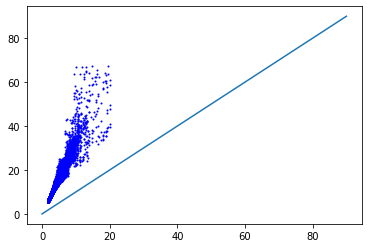

In [328]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list[0:1]], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

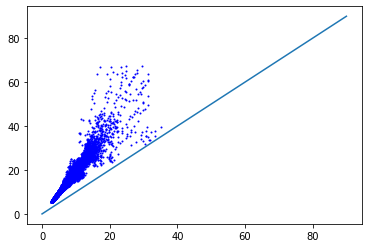

In [329]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list[0:2]], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

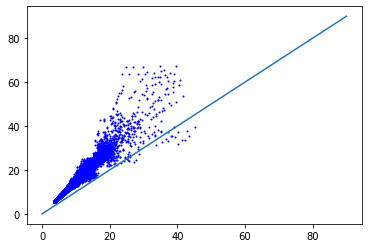

In [330]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list[0:3]], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

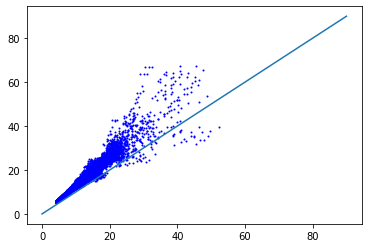

In [331]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list[0:4]], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

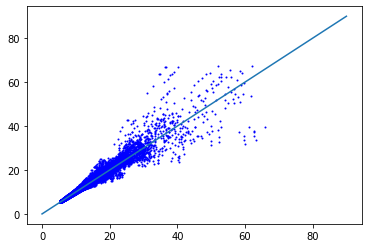

In [332]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list[:10]], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

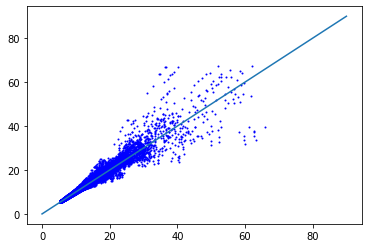

In [333]:
pred = np.sum([np.concatenate(ind_tree.prediction(x_train)) * l_rate for ind_tree in tree_list], axis = 0)
plt.plot(pred.reshape(-1), y_train[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

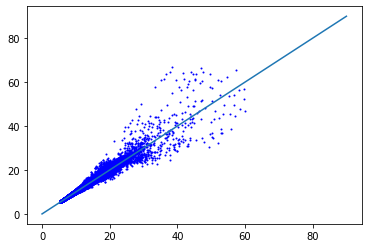

In [334]:
pred_test = np.sum([np.concatenate(ind_tree.prediction(x_test))* l_rate for ind_tree in tree_list], axis = 0)

plt.plot(pred_test.reshape(-1), pm2_5[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'true'}>

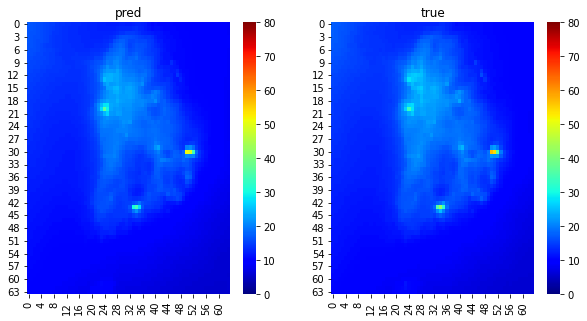

In [335]:
i = 0
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

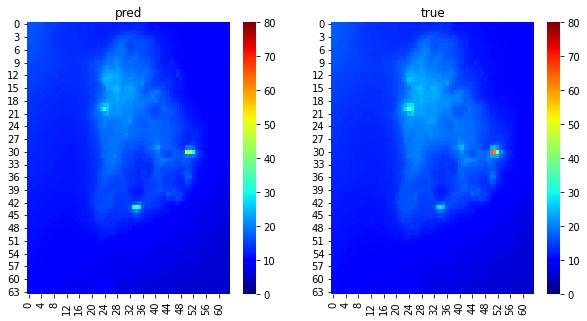

In [326]:
i = 1
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

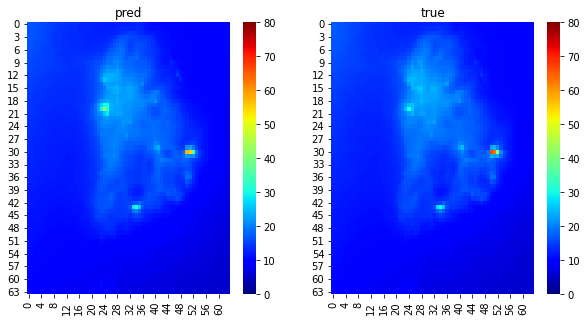

In [336]:
i = 2
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

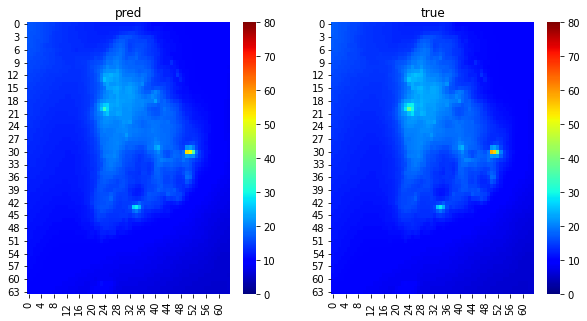

In [337]:
i = 3
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

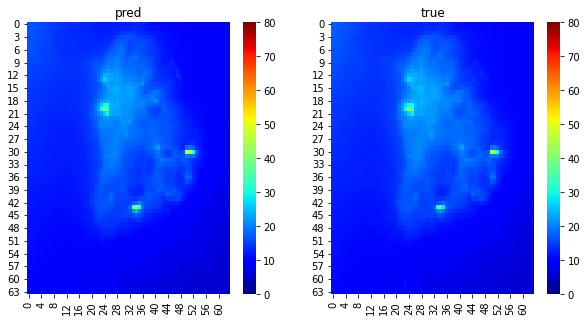

In [338]:
i = 4
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

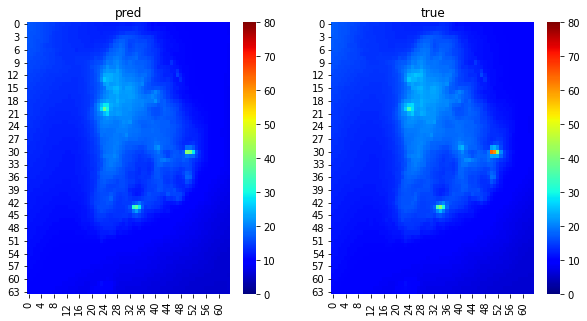

In [339]:
i = 5
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

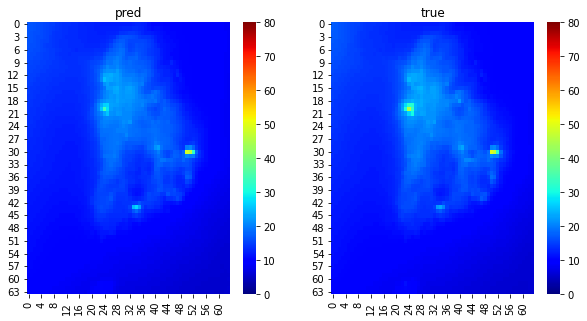

In [340]:
i = 6
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': '1'}>

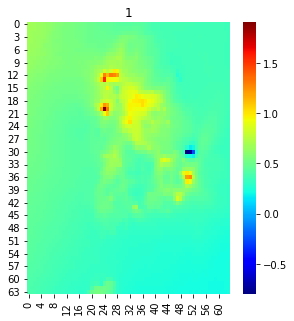

In [382]:
i = 3
fig = plt.figure(figsize = (10,5))
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('1')
sns.heatmap(tree_list[9].l_tree.y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1)


<AxesSubplot: title={'center': '1'}>

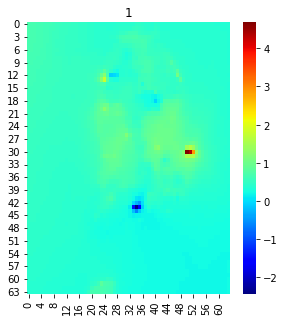

In [378]:
i = 6
fig = plt.figure(figsize = (10,5))
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('1')
sns.heatmap(tree_list[9].r_tree.y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1)
